문장을 입력해서 이진분류하는 모델에 대해서 알아보겠습니다. 언어가 시계열적인 의미가 있으므로, 이 언어를 문자로 표현한 문장도 시계열적인 의미가 있습니다. 모델에 입력하기 위해서 문장을 시계열수치로 인코딩하는 방법과 여러가지 이진분류 모델을 구성해보고, 학습 결과를 살펴보겠습니다. 이 모델들은 문장 혹은 시계열수치로 양성/음성을 분류하거나 이벤트 발생 유무를 감지하는 문제를 풀 수 있습니다. 

---
### 데이터셋 준비

IMDB에서 제공하는 영화 리뷰 데이터셋을 이용하겠습니다. 이 데이터셋은 훈련셋 25,000개, 시험셋 25,000개의 샘플을 제공합니다. 라벨은 1과 0으로 좋아요/싫어요로 지정되어 있습니다. 케라스에서 제공하는 imdb의 load_data() 함수을 이용하면 데이터셋을 쉽게 얻을 수 있습니다. 데이터셋은 이미 정수로 인코딩되어 있으며, 정수값은 단어의 빈도수를 나타냅니다. 모든 단어를 고려할 수 없으므로 빈도수가 높은 단어를 위주로 데이터셋을 생성합니다. 20,000번째로 많이 사용하는 단어까지만 데이터셋으로 만들고 싶다면, num_words 인자에 20000이라고 지정하면 됩니다. 

In [4]:
from keras.datasets import imdb
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=20000)

훈련셋의 데이터가 어떻게 구성되어 있는 지 살펴보겠습니다. x_train을 출력하면 다음과 같습니다.

In [ ]:
print(x_train)

총 25000개의 샘플이 있으며, 각 샘플은 영화 리뷰 한 건을 의미하며, 단어의 인덱스로 구성되어 있습니다. 'num_words=20000'으로 지정했기 때문에 빈도수가 20,000을 넘는 단어는 보이지가 않습니다. 훈련셋 25,000개를 다시 훈련셋 20,000개와 검증셋 5,000개로 분리합니다.

In [5]:
x_val = x_train[20000:]
y_val = y_train[20000:]
x_train = x_train[:20000]
y_train = y_train[:20000]

리뷰의 길이가 다르니 각 샘플의 길이가 다르겠죠? 적개는 수십 단어로 많게는 천 개 이상의 단어로 구성되어 있습니다. 모델의 입력으로 사용하려면 고정된 길이로 만들어야 하므로 케라스에서 제공되는 전처리 함수인 sequence의 pad_sequences() 함수를 사용합니다. 이 함수는 두 가지 역할을 수행합니다. 
* 문장을 maxlen 인자로 지정된 길이로 맞춰줍니다. 예를 들어 200으로 지정했다면 200보다 짧은 문장은 0으로 채워서 200단어로 맞춰주고 200보다 긴 문장은 200단어까지만 잘라냅니다.
* (num_samples, num_timesteps)으로 2차원의 numpy 배열로 만들어줍니다. maxlen을 200으로 지정하였다면, num_timesteps도 200이 됩니다.

In [7]:
from keras.preprocessing import sequence

x_train = sequence.pad_sequences(x_train, maxlen=200)
x_val = sequence.pad_sequences(x_val, maxlen=200)
x_test = sequence.pad_sequences(x_test, maxlen=200)

---
### 레이어 준비

본 장에서 새롭게 소개되는 블록들은 다음과 같습니다.

|블록|이름|설명|
|:-:|:-:|:-|
|![img](http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_Embedding_s.png)|Embedding|단어를 의미론적 기하공간에 매핑할 수 있도록 벡터화시킵니다.|
|![img](http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_Conv1D_s.png)|Conv1D|필터를 이용하여 지역적인 특징을 추출합니다.|
|![img](http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_GlobalMaxPooling1D_s.png)|GlobalMaxPooling1D|여러 개의 벡터 정보 중 가장 큰 벡터를 골라서 반환합니다.|
|![img](http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_MaxPooling1D_s.png)|MaxPooling1D|입력벡터에서 특정 구간마다 값을 골라 벡터를 구성한 후 반환합니다.|

---
### 모델 준비

영상을 입력하여 다중클래스분류를 하기 위해 `다층퍼셉트론 신경망 모델`, `순환 신경망 모델`, `컨볼루션 신경망 모델`, `순환 컨볼루션 신경망 모델`을 준비했습니다.

#### 다층퍼셉트론 신경망 모델

임베딩(Embedding) 레이어로 단어들을 인코딩한 후 Dense 레이어를 통해 분류하는 다층퍼셉트론 신경망 모델입니다. 임베딩 레이어의 인자 의미는 다음과 같습니다.
* 첫번째 인자(input_dim) : 단어 사전의 크기를 말하며 총 20,000개의 단어 종류가 있다는 의미입니다. 이 값은 앞서 imdb.load_data() 함수의 num_words 인자값과 동일해야 합니다. 
* 두번째 인자(output_dim) : 단어를 인코딩 한 후 나오는 벡터 크기 입니다. 이 값이 128이라면 단어를 128차원의 의미론적 기하공간에 나타낸다는 의미입니다. 단순하게 빈도수만으로 단어를 표시한다면, 10과 11은 빈도수는 비슷하지만 단어로 볼 때는 전혀 다른 의미를 가지고 있습니다. 하지만 의미론적 기하공간에서는 거리가 가까운 두 단어는 의미도 유사합니다. 즉 임베딩 레이어는 입력되는 단어를 의미론적으로 잘 설계된 공간에 위치시켜 벡터로 수치화 시킨다고 볼 수 있습니다.
* input_length : 단어의 수 즉 문장의 길이를 나타냅니다. 임베딩 레이어의 출력 크기는 샘플 수 * output_dim * input_lenth가 됩니다. 임베딩 레이어 다음에 Flatten 레이어가 온다면 반드시 input_lenth를 지정해야 합니다. 플래튼 레이어인 경우 입력 크기가 알아야 이를 1차원으로 만들어서 Dense 레이어에 전달할 수 있기 때문입니다.


    model = Sequential()
    model.add(Embedding(20000, 128, input_length=200))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

![img](http://tykimos.github.com/Keras/warehouse/2017-8-17-Text_Input_Binary_Classification_Model_Recipe_1m.png)

#### 순환 신경망 모델

문장을 단어들의 시퀀스로 간주하고 순환(LSTM) 레이어의 입력으로 구성한 모델입니다. 임베딩 레이어 다음에 LSTM 레이어가 오는 경우에는 임베딩 레이어에 input_length 인자를 따로 설정할 필요는 없습니다. 입력 문장의 길이에 따라 input_length가 자동으로 정해지고, 이것이 LSTM 레이어에는 timesteps으로 입력되기 때문입니다. 블록으로 표현한다면 예제에서는 문장의 길이가 200 단어이므로, LSTM 블록 200개가 이어져있다고 생각하면 됩니다. 

    model = Sequential()
    model.add(Embedding(20000, 128))
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))
    
![img](http://tykimos.github.com/Keras/warehouse/2017-8-17-Text_Input_Binary_Classification_Model_Recipe_2m.png)

#### 컨볼루션 신경망 모델

문장 해석에 컨볼루션(Conv1D) 레이어를 이용한 모델입니다. 컨볼루션(Conv1D) 레이어는 위치에 상관없이 지역적인 특징을 잘 뽑아냅니다. 이 레이어를 문장에 적용한다면 주요 단어가 문장 앞 혹은 문장 뒤에 있더라도 놓치지 않고 전후 문맥을 보면서 특징을 잘 뽑아낼 수 있습니다. 글로벌 맥스풀링(GlobalMaxPooling1D) 레이어는 컨볼루션 레이어가 문장을 훑어가면서 나온 특징벡터들 중 가장 큰 벡터를 골라줍니다. 즉 문맥을 보면서 주요 특징을 뽑아내고, 그 중 가장 두드러지는 특징을 고르는 것입니다.

    model = Sequential()
    model.add(Embedding(20000, 128, input_length=200))
    model.add(Dropout(0.2))
    model.add(Conv1D(256,
                     3,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

![img](http://tykimos.github.com/Keras/warehouse/2017-8-17-Text_Input_Binary_Classification_Model_Recipe_3m.png)

#### 순환 컨볼루션 신경망 모델

컨볼루션 레이어에서 나온 특징벡터들을 맥스풀링(MaxPooling1D)를 통해 1/4로 줄여준 다음 LSTM의 입력으로 넣어주는 모델입니다. 이때 맥스풀링은 특징벡터 크기를 줄여주는 것이 아니라 특징벡터 수를 줄여줍니다. 즉 200개 단어가 컨볼루션 레이어를 통과하면 256 크기를 갖는 특징벡터가 198개가 생성되고, 맥스풀링은 특징벡터 198개 중 49개를 골라줍니다. 따라서 LSTM 레이어의 timesteps는 49개가 됩니다. 참고로 input_dim은 그대로 256입니다.

    model = Sequential()
    model.add(Embedding(20000, 128, input_length=200))
    model.add(Dropout(0.2))
    model.add(Conv1D(256,
                     3,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))

![img](http://tykimos.github.com/Keras/warehouse/2017-8-17-Text_Input_Binary_Classification_Model_Recipe_4m.png)

순환 신경망 모델과 순환 컨볼루션 신경망 모델 구성에서 LSTM의 입력만 비교하면 다음과 같습니다. 문장의 길이 즉 단어의 수가 200일 때,
* 순환 신경망 모델 : LSTM에 입력되는 타임스텝은 Embedding 출력 타임스텝으로 200이고, 속성은 Embedding에서 인코딩된 128입니다.
* 순환 컨볼루션 신경망 모델 : LSTM에 입력되는 타임스텝은 49, 속성은 256입니다. 타임스텝이 49인 이유는 Conv1D에서 200단어를 받아 198개를 반환하고, 이를 다시 MaxPooling1D에 의해 1/4배로 줄어들어 49가 된 것입니다. 속성이 256인 이유는 Conv1D가 Embedding 출력인 128 벡터를 입력받아 256으로 반환되기 때문입니다.

즉 Conv1D와 MaxPooling1D에 의해 타입스텝은 줄어들었고, 

---
### 전체 소스

앞서 살펴본 `다층퍼셉트론 신경망 모델`, `순환 신경망 모델`, `컨볼루션 신경망 모델`, `순환 컨볼루션 신경망 모델`의 전체 소스는 다음과 같습니다. 

#### 다중퍼셉트론 신경망 모델

Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 25s - loss: 0.4136 - acc: 0.7916 - val_loss: 0.3069 - val_acc: 0.8728
Epoch 2/2
20000/20000 [==============================] - 25s - loss: 0.0534 - acc: 0.9810 - val_loss: 0.4522 - val_acc: 0.8484


Using Theano backend.


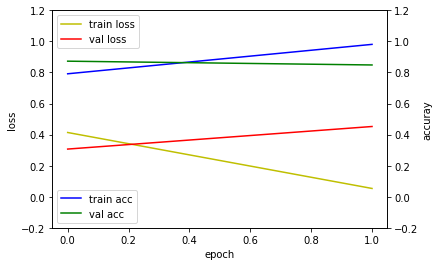

24640/25000 [============================>.] - ETA: 0s## evaluation loss and_metrics ##
[0.46098566806793212, 0.84436000003814693]


In [1]:
# 0. 사용할 패키지 불러오기
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import Flatten

max_features = 20000
text_max_words = 200

# 1. 데이터셋 생성하기

# 훈련셋과 시험셋 불러오기
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 훈련셋과 검증셋 분리
x_val = x_train[20000:]
y_val = y_train[20000:]
x_train = x_train[:20000]
y_train = y_train[:20000]

# 데이터셋 전처리 : # cut texts after this number of words (among top max_features most common words)
x_train = sequence.pad_sequences(x_train, maxlen=text_max_words)
x_val = sequence.pad_sequences(x_val, maxlen=text_max_words)
x_test = sequence.pad_sequences(x_test, maxlen=text_max_words)

# 2. 모델 구성하기
model = Sequential()
model.add(Embedding(max_features, 128, input_length=text_max_words))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 3. 모델 학습과정 설정하기
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=2, batch_size=64, validation_data=(x_val, y_val))

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-0.2, 1.2])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([-0.2, 1.2])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

#### 순환 신경망 모델

Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 139s - loss: 0.4392 - acc: 0.7882 - val_loss: 0.3288 - val_acc: 0.8658
Epoch 2/2
20000/20000 [==============================] - 140s - loss: 0.2295 - acc: 0.9137 - val_loss: 0.3181 - val_acc: 0.8702


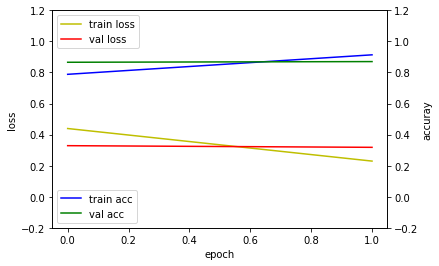

25000/25000 [==============================] - 37s    
## evaluation loss and_metrics ##
[0.34819652654647826, 0.86111999996185307]


In [2]:
# 0. 사용할 패키지 불러오기
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Flatten

max_features = 20000
text_max_words = 200

# 1. 데이터셋 생성하기

# 훈련셋과 시험셋 불러오기
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 훈련셋과 검증셋 분리
x_val = x_train[20000:]
y_val = y_train[20000:]
x_train = x_train[:20000]
y_train = y_train[:20000]

# 데이터셋 전처리 : # cut texts after this number of words (among top max_features most common words)
x_train = sequence.pad_sequences(x_train, maxlen=text_max_words)
x_val = sequence.pad_sequences(x_val, maxlen=text_max_words)
x_test = sequence.pad_sequences(x_test, maxlen=text_max_words)

# 2. 모델 구성하기
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

# 3. 모델 학습과정 설정하기
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=2, batch_size=64, validation_data=(x_val, y_val))

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-0.2, 1.2])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([-0.2, 1.2])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

#### 컨볼루션 신경망 모델

Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 68s - loss: 0.4382 - acc: 0.7823 - val_loss: 0.2904 - val_acc: 0.8762
Epoch 2/2
20000/20000 [==============================] - 67s - loss: 0.2153 - acc: 0.9157 - val_loss: 0.3163 - val_acc: 0.8690


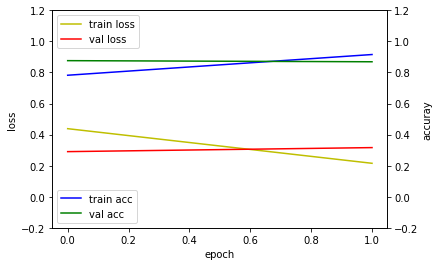

24960/25000 [============================>.] - ETA: 0s## evaluation loss and_metrics ##
[0.32697385798454287, 0.86023999996185307]


In [4]:
# 0. 사용할 패키지 불러오기
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Flatten, Dropout
from keras.layers import Conv1D, GlobalMaxPooling1D

max_features = 20000
text_max_words = 200

# 1. 데이터셋 생성하기

# 훈련셋과 시험셋 불러오기
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 훈련셋과 검증셋 분리
x_val = x_train[20000:]
y_val = y_train[20000:]
x_train = x_train[:20000]
y_train = y_train[:20000]

# 데이터셋 전처리 : # cut texts after this number of words (among top max_features most common words)
x_train = sequence.pad_sequences(x_train, maxlen=text_max_words)
x_val = sequence.pad_sequences(x_val, maxlen=text_max_words)
x_test = sequence.pad_sequences(x_test, maxlen=text_max_words)

# 2. 모델 구성하기
model = Sequential()
model.add(Embedding(max_features, 128, input_length=text_max_words))
model.add(Dropout(0.2))
model.add(Conv1D(256,
                 3,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# 3. 모델 학습과정 설정하기
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=2, batch_size=64, validation_data=(x_val, y_val))

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-0.2, 1.2])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([-0.2, 1.2])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

# 7. 모델 사용하기
#yhat_test = model.predict(xhat_test, batch_size=64)

#### 순환 컨볼루션 신경망 모델

Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 191s - loss: 0.3976 - acc: 0.8088 - val_loss: 0.3251 - val_acc: 0.8636
Epoch 2/2
20000/20000 [==============================] - 185s - loss: 0.1895 - acc: 0.9301 - val_loss: 0.3049 - val_acc: 0.8764


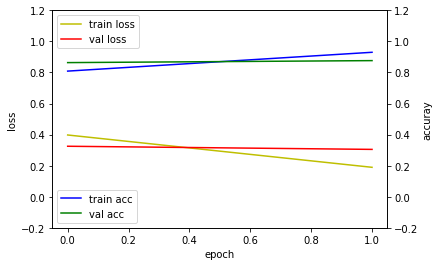

25000/25000 [==============================] - 63s    
## evaluation loss and_metrics ##
[0.33583777394294739, 0.85948000000000002]


In [10]:
# 0. 사용할 패키지 불러오기
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D

max_features = 20000
text_max_words = 200

# 1. 데이터셋 생성하기

# 훈련셋과 시험셋 불러오기
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 훈련셋과 검증셋 분리
x_val = x_train[20000:]
y_val = y_train[20000:]
x_train = x_train[:20000]
y_train = y_train[:20000]

# 데이터셋 전처리 : # cut texts after this number of words (among top max_features most common words)
x_train = sequence.pad_sequences(x_train, maxlen=text_max_words)
x_val = sequence.pad_sequences(x_val, maxlen=text_max_words)
x_test = sequence.pad_sequences(x_test, maxlen=text_max_words)

# 2. 모델 구성하기
model = Sequential()
model.add(Embedding(max_features, 128, input_length=text_max_words))
model.add(Dropout(0.2))
model.add(Conv1D(256,
                 3,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

# 3. 모델 학습과정 설정하기
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=2, batch_size=64, validation_data=(x_val, y_val))

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-0.2, 1.2])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([-0.2, 1.2])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

---

### 학습결과 비교

단순한 다층퍼셉트론 신경망 모델보다는 순환 레이어나 컨볼루션 레이어를 이용한 모델의 성능이 더 높았습니다. 

|다층퍼셉트론 신경망 모델|순환 신경망 모델|컨볼루션 신경망 모델|순환 컨볼루션 신경망 모델
|:-:|:-:|:-:|:-:|
|![img](http://tykimos.github.com/Keras/warehouse/2017-8-17-Text_Input_Binary_Classification_Model_Recipe_output_15_2.png)|![img](http://tykimos.github.com/Keras/warehouse/2017-8-17-Text_Input_Binary_Classification_Model_Recipe_output_17_1.png)|![img](http://tykimos.github.com/Keras/warehouse/2017-8-17-Text_Input_Binary_Classification_Model_Recipe_output_19_1.png)|![img](http://tykimos.github.com/Keras/warehouse/2017-8-17-Text_Input_Binary_Classification_Model_Recipe_output_21_1.png)|

---

### 요약

문장을 입력하여 이진분류할 수 있는 여러가지 모델을 살펴보고, 그 성능을 비교해봤습니다. 시계열 데이터를 처리하기 위한 모델은 다층퍼셉트론 신경망 모델부터 컨볼루션 신경망, 순환 신경망 모델 등 다양하게 구성할 수 있습니다. 복잡한 모델일수록 정확도가 높은 것은 아니지만 여러 모델과 파라미터로 적절한 모델을 개발해야 합니다.

---

### 같이 보기

* [강좌 목차](https://tykimos.github.io/Keras/lecture/)
* [시계열수치입력 수치예측 모델 레시피](https://tykimos.github.io/Keras/2017/08/17/Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe)
* [문장(시계열수치)입력 다중클래스분류 모델 레시피](https://tykimos.github.io/Keras/2017/08/17/Text_Input_Multiclass_Classification_Model_Recipe)    